# Lista 8


In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from nltk.corpus import stopwords
import nltk
import warnings
warnings.filterwarnings('ignore')

In [256]:
random_state = 222

## zad 1

wczytam zbiór recenzji filmowych z IMDB. Trzeba je potem zmienić z liczbowych na słowa

<center>
    <img src="./screens/l8-imdb.png" style="width: 45%;"><br>
</center>

In [257]:
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=10000)

<center>
    <img src="./screens/l8-slowa.png" style="width: 45%;"><br>
</center>

In [258]:
word_index = keras.datasets.imdb.get_word_index()
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0 # padding, używamy do wyrównywania długości recenzji
word_index["<START>"] = 1 # początek recenzji
word_index["<UNK>"] = 2 # unknown
word_index["<UNUSED>"] = 3 # unused

# Reverse word index to get word from integer
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

teraz dekoduje liczby na słowa

In [259]:
X = [decode_review(r) for r in train_data[:5000]] + [decode_review(r) for r in test_data[:5000]]
y = list(train_labels[:5000]) + list(test_labels[:5000])

X[0]

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [260]:
y[0]

np.int64(1)

robie z tego pd

In [261]:
df = pd.DataFrame({
    "X": X,
    "y": y
})
df['sentiment_label'] = df['y'].map({0: 'negative', 1: 'positive'})

df.head()

,X,y,sentiment_label
0,<START> this film was just brilliant casting l...,1,positive
1,<START> big hair big boobs bad music and a gia...,0,negative
2,<START> this has to be one of the worst films ...,0,negative
3,<START> the <UNK> <UNK> at storytelling the tr...,1,positive
4,<START> worst mistake of my life br br i picke...,0,negative


zapoznaje się z danymi

In [262]:
print(f"liczba recenzji: {len(df)}")

print()
print()

print(f"rozkład klas:")
print(df['sentiment_label'].value_counts())

print()
print()

print(f"procentowy rozkład:")
print(df['sentiment_label'].value_counts(normalize=True) * 100)

liczba recenzji: 10000


rozkład klas:
sentiment_label
negative    5025
positive    4975
Name: count, dtype: int64


procentowy rozkład:
sentiment_label
negative    50.25
positive    49.75
Name: proportion, dtype: float64


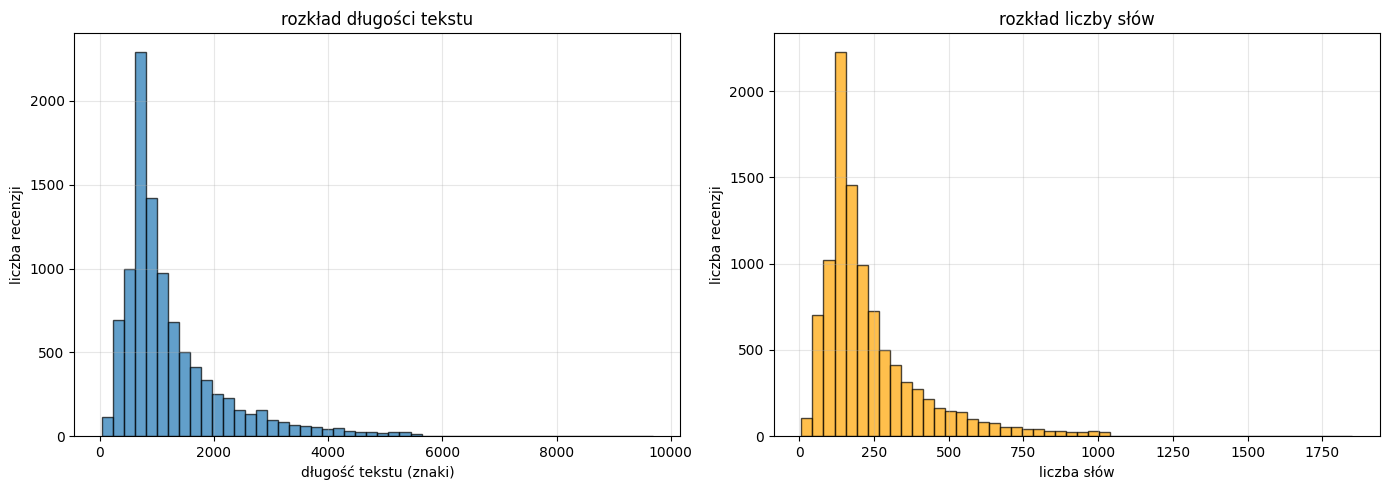

In [263]:
df['text_length'] = df['X'].apply(len)
df['word_count'] = df['X'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('długość tekstu (znaki)')
axes[0].set_ylabel('liczba recenzji')
axes[0].set_title('rozkład długości tekstu')
axes[0].grid(True, alpha=0.3)

axes[1].hist(df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('liczba słów')
axes[1].set_ylabel('liczba recenzji')
axes[1].set_title('rozkład liczby słów')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## zad 2

Przygotowanie danych tekstowych: Przeprowadzę pre-processing danych tekstowych, który obejmuje:
- usunięcie znaków interpunkcyjnych i cyfr
- konwersję tekstu na małe litery
- usunięcie stopwords (słów-wypełniaczy)

In [264]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

SPECIAL_TOKENS = {"<PAD>", "<START>", "<UNK>", "<UNUSED>"}

def preprocess_text(text):
    tokens = text.split()
    cleaned = []
    prev_word = None

    for tok in tokens:
        tok_upper = tok.upper()
        if tok_upper in SPECIAL_TOKENS:
            cleaned.append(tok_upper)
            prev_word = tok_upper
            continue

        tok_norm = tok.lower()
        tok_norm = re.sub(r'[^a-z\s]', '', tok_norm)
        if tok_norm and tok_norm not in stop_words:
            # usuwamy duplikaty kolejnych słów
            if tok_norm != prev_word:
                cleaned.append(tok_norm)
            prev_word = tok_norm

    return ' '.join(cleaned)

[nltk_data] Downloading package stopwords to /home/piotr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


oczyszczam dane

In [265]:
df['review_processed'] = df['X'].apply(preprocess_text)

print("przed pre-processingiem:")
print(df['X'].iloc[0][:200])

print()

print("po pre-processingiem:")
print(df['review_processed'].iloc[0][:200])


przed pre-processingiem:
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and 

po pre-processingiem:
<START> film brilliant casting location scenery story direction everyones really suited part played could imagine robert <UNK> amazing actor director <UNK> father came scottish island loved fact real 


In [266]:
df['word_count_processed'] = df['review_processed'].apply(lambda x: len(x.split()) if x.strip() else 0)

print("statystyki po pre-processingiem:")
print(f"średnia liczba słów przed: {df['word_count'].mean():.2f}")
print(f"średnia liczba słów po: {df['word_count_processed'].mean():.2f}")
print(f"redukcja: {(1 - df['word_count_processed'].mean() / df['word_count'].mean()) * 100:.2f}%")

statystyki po pre-processingiem:
średnia liczba słów przed: 235.55
średnia liczba słów po: 122.80
redukcja: 47.87%


In [267]:
df.head()

,X,y,sentiment_label,text_length,word_count,review_processed,word_count_processed
0,<START> this film was just brilliant casting l...,1,positive,1143,218,<START> film brilliant casting location scener...,97
1,<START> big hair big boobs bad music and a gia...,0,negative,975,189,<START> big hair big boobs bad music giant saf...,100
2,<START> this has to be one of the worst films ...,0,negative,700,141,<START> one worst films friends watching film ...,66
3,<START> the <UNK> <UNK> at storytelling the tr...,1,positive,2909,550,<START> <UNK> <UNK> storytelling traditional s...,285
4,<START> worst mistake of my life br br i picke...,0,negative,729,147,<START> worst mistake life br picked movie tar...,77


In [268]:
X_train = df['review_processed'].iloc[:5000]
X_test = df['review_processed'].iloc[5000:]

y_train = df['y'].iloc[:5000]
y_test = df['y'].iloc[5000:]

X_train[0]

'<START> film brilliant casting location scenery story direction everyones really suited part played could imagine robert <UNK> amazing actor director <UNK> father came scottish island loved fact real connection film witty remarks throughout film great brilliant much bought film soon released <UNK> would recommend everyone watch fly fishing amazing really cried end sad know say cry film must good definitely also <UNK> two little boys played <UNK> norman paul brilliant children often left <UNK> list think stars play grown big profile whole film children amazing praised done dont think whole story lovely true someones life shared us'

In [269]:
y_train[0]

np.int64(1)

## zad 3

przekształcę dane tekstowe na format numeryczny, który może być użyty przez model uczenia maszynowego. zastosuję bag of words i word embeding.

In [270]:
def filter_tokens(text):
    return ' '.join([w for w in text.split() if w not in SPECIAL_TOKENS.union({"br"})])

X_train_clean = [filter_tokens(r) for r in X_train]
X_test_clean = [filter_tokens(r) for r in X_test]

X_train_clean[0]
X_test_clean[0]

'please give one miss rest cast rendered terrible performances show flat dont know michael madison could allowed one plate almost seemed know wasnt going work performance quite madison fans give miss'

1. bag of words

In [271]:
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = bow_vectorizer.fit_transform(X_train_clean)
X_test_bow = bow_vectorizer.transform(X_test_clean)

print(f"size: {len(bow_vectorizer.vocabulary_)}")

size: 5000


word embeding

In [272]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_test_tfidf = tfidf_vectorizer.transform(X_test_clean)

print(f"size: {len(tfidf_vectorizer.vocabulary_)}")

size: 5000


Najpopularniejsze słowa

In [273]:
feature_names_bow = bow_vectorizer.get_feature_names_out()
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

positive_indices = np.where(y_train == 1)[0]
negative_indices = np.where(y_train == 0)[0]

positive_word_counts = X_train_bow[positive_indices].sum(axis=0).A1
negative_word_counts = X_train_bow[negative_indices].sum(axis=0).A1

top_positive_words = [feature_names_bow[i] for i in np.argsort(positive_word_counts)[-10:][::-1]]
top_negative_words = [feature_names_bow[i] for i in np.argsort(negative_word_counts)[-10:][::-1]]

print("top dycha dla pozytywnych:")
for i, word in enumerate(top_positive_words, 1):
    print(f"{i}. {word}")

print()

print("top ten dla negatywnych:")
for i, word in enumerate(top_negative_words, 1):
    print(f"{i}. {word}")

top dycha dla pozytywnych:
1. film
2. movie
3. one
4. like
5. good
6. well
7. time
8. story
9. great
10. see

top ten dla negatywnych:
1. movie
2. film
3. one
4. like
5. even
6. good
7. bad
8. would
9. really
10. time


: D, dla pozytywnych mamy "good", "well", "great" - a dla negatywnych "bad" -> działa:) Porównajmy jeszcze dla drugiego


In [274]:
positive_tfidf = X_train_tfidf[positive_indices].sum(axis=0).A1
negative_tfidf = X_train_tfidf[negative_indices].sum(axis=0).A1

top_positive_tfidf = [feature_names_tfidf[i] for i in np.argsort(positive_tfidf)[-10:][::-1]]
top_negative_tfidf = [feature_names_tfidf[i] for i in np.argsort(negative_tfidf)[-10:][::-1]]

print("top 10 dla pozytywnych (TF-IDF):")
for i, word in enumerate(top_positive_tfidf, 1):
    print(f"{i}. {word}")

print()

print("top 10 dla negatywnych (TF-IDF):")
for i, word in enumerate(top_negative_tfidf, 1):
    print(f"{i}. {word}")


top 10 dla pozytywnych (TF-IDF):
1. movie
2. film
3. one
4. like
5. great
6. good
7. story
8. well
9. see
10. time

top 10 dla negatywnych (TF-IDF):
1. movie
2. film
3. one
4. like
5. bad
6. even
7. good
8. would
9. really
10. time


również działa. Weźmiemy, więc te drugą

In [275]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

## zad 4

Pora na budowę modelu, ja zdecydowałem się na prostą sieć neuronową. Architektura

In [276]:
model = keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.7),
    layers.Dense(16, activation='leaky_relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [277]:
model.compile(
    optimizer='nadam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Epoch 1/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6189 - loss: 0.6662 - val_accuracy: 0.7960 - val_loss: 0.5986
Epoch 2/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8091 - loss: 0.5052 - val_accuracy: 0.8680 - val_loss: 0.3988
Epoch 3/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8824 - loss: 0.3385 - val_accuracy: 0.8704 - val_loss: 0.3174
Epoch 4/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9152 - loss: 0.2505 - val_accuracy: 0.8728 - val_loss: 0.3078
Epoch 5/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9365 - loss: 0.1915 - val_accuracy: 0.8720 - val_loss: 0.3157
Epoch 6/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9552 - loss: 0.1506 - val_accuracy: 0.8688 - val_loss: 0.3318
Epoch 7/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9683 - loss: 0.1181 - val_accuracy: 0.8664 - val_loss: 0.3614
Epoch 8/200
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9701 - loss: 0.0922 - val_accu

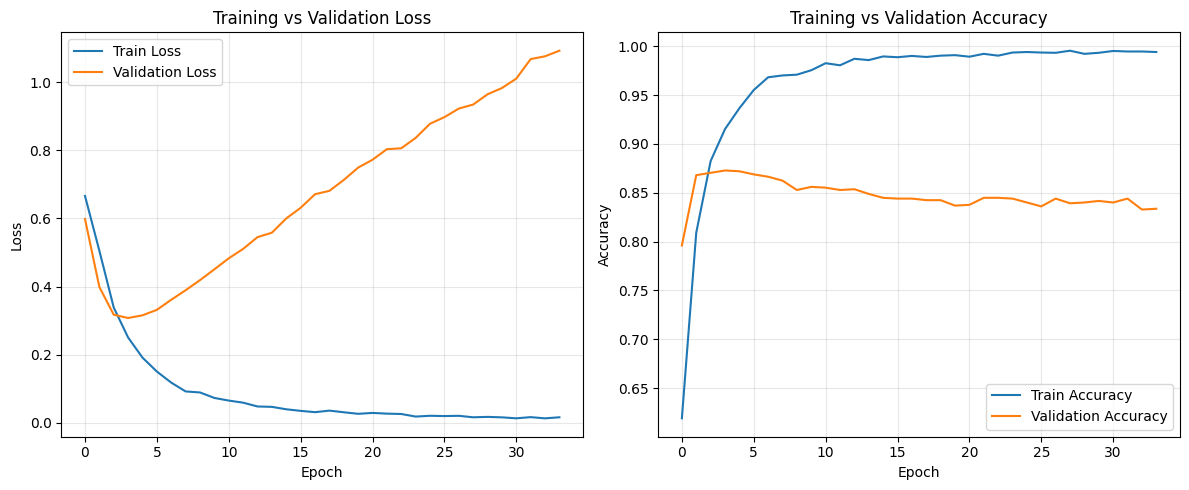

In [278]:
early_stop = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True
)

history = model
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=24,
    validation_split=0.25,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [279]:
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step


## zad 5

oceńmy więc model

In [280]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8574
Precision: 0.8405
Recall: 0.8720


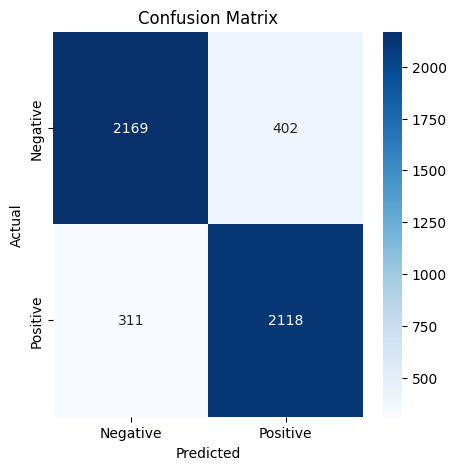

In [281]:
cm = confusion_matrix(y_test, y_pred)
labels = ['Negative', 'Positive']

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## zad 6

predykcja na nowych danych. Stworzę kilka własnych recenzji. Przetworzę je w taki sam sposób jak dane treningowe i użyję wytrenowanego modelu do predykcji ich wydźwięku. Sprawdzę, czy model poprawnie je sklasyfikował.

In [288]:
custom_reviews = [
    "nice film to chillout after math exam about life insurance", # positive
    "bad day, i hate my life, i wrote bad exam, bad score, bad film, girlfriend left me - i dont recoment",  # negative
    "the movie was okay mnothing special, but not bad either. It had some good moments and some boring parts. average" # neutral
]

review_labels = ['Positive', 'Negative', 'Neutral']

preprocesing

In [289]:
custom_reviews_processed = [preprocess_text(review) for review in custom_reviews]

wektoryzacja

In [290]:
custom_tfidf = tfidf_vectorizer.transform(custom_reviews_processed)

In [294]:
y_pred = (model.predict(custom_tfidf) > 0.5).astype(int).flatten()
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([1, 0, 0])

In [296]:
for review, true_label, pred in zip(custom_reviews, review_labels, y_pred):
    pred_label = "Positive" if pred == 1 else "Negative"
    print("review:", review)
    print("expected:", true_label)
    print("predicted:", pred_label)
    print()
    print()

review: nice film to chillout after math exam about life insurance
expected: Positive
predicted: Positive


review: bad day, i hate my life, i wrote bad exam, bad score, bad film, girlfriend left me - i dont recoment
expected: Negative
predicted: Negative


review: the movie was okay mnothing special, but not bad either. It had some good moments and some boring parts. average
expected: Neutral
predicted: Negative




Wniosek: model jest całkiem niezły